In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Datos a tener en consideración:

R: Número de días desde la última compra

F: Frecuencia, número de transacciones

M: Total de ingresos de las transacciones

In [3]:
#Lectura de la BD preprocesada
df_bd_preprocesada = pd.read_csv('BD/OnlineRetail_Preprocesada.csv', sep=',', encoding = 'unicode_escape')

In [4]:
#Creamos una nueva columna llamada Ingresos
df_bd_preprocesada['Ingresos'] = df_bd_preprocesada['Quantity']*df_bd_preprocesada['UnitPrice']
rfm_m = df_bd_preprocesada.groupby('CustomerID')['Ingresos'].sum()
rfm_m = rfm_m.reset_index()

#Creamos una nueva columna llamada Frecuencia
rfm_f = df_bd_preprocesada.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frecuencia']

#Se fucionan las dos nuevas columnas y se asocian al CustomerID correspondiente
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')

In [5]:
#Creamos un nuevo atributo llamado ÚltimaCompra
df_bd_preprocesada['InvoiceDate'] = pd.to_datetime(df_bd_preprocesada['InvoiceDate'])

#Conocemos la última fecha donde se realizó una transacción
max_date = max(df_bd_preprocesada['InvoiceDate'])
max_date
#Conocemos la diferencia entre la última transacción y la fecha actual
df_bd_preprocesada['Diff'] = max_date - df_bd_preprocesada['InvoiceDate']

#Calculamos la última fecha de los clientes para saber la actual
rfm_p = df_bd_preprocesada.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()

#Extraemos el número de días desde la última transacción
rfm_p['Diff'] = rfm_p['Diff'].dt.days

#Obtenemos los datos finales de R, F y M
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Ingresos', 'Frecuencia', 'ÚltimaCompra']

In [6]:
print(df_bd_preprocesada.head(5))
print(rfm.head(5))

   Unnamed: 0  InvoiceNo StockCode                          Description  \
0           0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1           1     536365     71053                  WHITE METAL LANTERN   
2           2     536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3           3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4           4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

   Quantity         InvoiceDate  UnitPrice  CustomerID         Country  \
0         6 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2         8 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
3         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
4         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   

   Ingresos              Diff  
0     15.30 373 days 04:24:00  
1     20.34 373 days 04:24:00  
2     22

In [8]:
#Reescalamos los atributos
rfm_df = rfm[['Ingresos', 'Frecuencia', 'ÚltimaCompra']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Ingresos', 'Frecuencia', 'ÚltimaCompra']
print(rfm_df_scaled.head(5))

   Ingresos  Frecuencia  ÚltimaCompra
0  8.363977   -0.396968      2.334858
1  0.251779    0.405730     -0.905199
2 -0.027938   -0.263924     -0.175186
3 -0.032357   -0.077663     -0.735196
4 -0.190780   -0.326011      2.174855


################## COMENZAMOS EL CLUSTERING DE K-MEANS ##################

In [15]:
kmeans = KMeans(n_clusters=9, max_iter=50) #MODIFICAMOS LA CANTIDAD DE ITERACIONES Y NUMERO DE CLUSTERS
kmeans.fit(rfm_df_scaled)
kmeans.labels_


array([5, 0, 7, ..., 0, 8, 0])

In [16]:
#Ahora encontramos el número óptimo de Clusters
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

print("Valores:\n")
for num_clusters in range_n_clusters:
    
    #Inicializamos k-means
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    #Obtenemos valor de distancia entre los clusters (desde el centro al mas lejano)
    valor = silhouette_score(rfm_df_scaled, cluster_labels)
    print("\n")
    print("Para n_clusters={0}, el valor es is {1}".format(num_clusters, valor))



Valores:



Para n_clusters=2, el valor es is 0.9312414894281854


Para n_clusters=3, el valor es is 0.6023126726335443


Para n_clusters=4, el valor es is 0.6011885408558991


Para n_clusters=5, el valor es is 0.6165940247929412


Para n_clusters=6, el valor es is 0.5904310761500766


Para n_clusters=7, el valor es is 0.5283752460272697


Para n_clusters=8, el valor es is 0.5243764313579502


Para n_clusters=9, el valor es is 0.4838027668268491


Para n_clusters=10, el valor es is 0.4336983769661903


In [17]:
#Podemos usar otros parámetros para ejecutar k-means. Disminuimos la cantidad de clusters
kmeans = KMeans(n_clusters=10, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_
rfm['Cluster_Id'] = kmeans.labels_
print(rfm.head(5))

   CustomerID  Ingresos  Frecuencia  ÚltimaCompra  Cluster_Id
0     12346.0  77183.60           1           325           8
1     12347.0   4310.00         182             1           9
2     12348.0   1797.24          31            74           0
3     12349.0   1757.55          73            18           5
4     12350.0    334.40          17           309           2


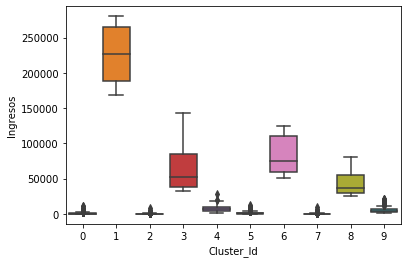

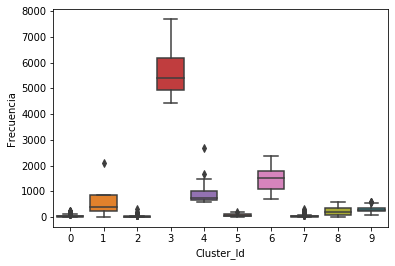

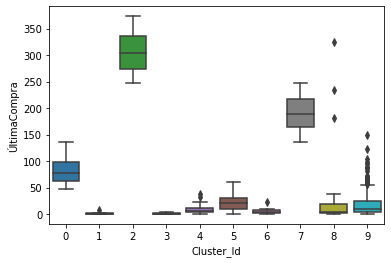

In [18]:
#Utilizamos un BoxPlot para visualizar los Clusters_Id vs Ingresos
sns.boxplot(x='Cluster_Id', y='Ingresos', data=rfm)
plt.show()

#Utilizamos un BoxPlot para visualizar los Clusters_Id vs Frecuencia
sns.boxplot(x='Cluster_Id', y='Frecuencia', data=rfm)
plt.show()

#Utilizamos un BoxPlot para visualizar los Clusters_Id vs Número de días desde última compra
sns.boxplot(x='Cluster_Id', y='ÚltimaCompra', data=rfm)
plt.show() 